In [3]:
import numpy as np
import pandas as pd
import csv
import os
import matplotlib
import matplotlib.pyplot as plt
import math
import torch
import spinup
import multiprocessing as mp

from torch.autograd import Variable
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from spinup.algos.pytorch.ddpg.core import MLPActorCritic

%matplotlib notebook

In [4]:
from src import *
from src.constants import DT, MAX_X, MAX_Y, BALL_ERROR_SCALING, BALL_D_ERROR_SCALING, BALL_INTEGRAL_ERROR_SCALING

In [5]:
train = False

In [6]:
with open('src/data/benchmark_trajectory.json') as json_file:
    benchmark_data = json.load(json_file)

In [7]:
t = np.array(benchmark_data['t'])
test_trajectory = np.array(benchmark_data['target'])
benchmark_trajectory = np.array(benchmark_data['trajectory'])
benchmark_angle = np.array(benchmark_data['angle'])
benchmark_u = np.array(benchmark_data['u'])

# Exploration

In [8]:
epoch = 200

In [9]:
root = 'src/data/dyn_pid_controller_1d/exploratory_penality'

In [18]:
def train_ddpg(env, ac, reward_fn, w, hidden_size, activation, name, replay_size, show_benchmark=False):
    if train:
        spinup.ddpg_pytorch(env_fn_gen(env, reward_fn, w),
                                actor_critic = ac,    
                                ac_kwargs = dict(hidden_sizes=hidden_size, activation=activation), 
                                seed = 0, 
                                steps_per_epoch = 1100, 
                                epochs = epoch, 
                                replay_size = replay_size, 
                                gamma = 0.99, 
                                polyak = 0.995, 
                                pi_lr = 0.001,
                                q_lr = 0.001,
                                batch_size = 500, 
                                start_steps = 15000,
                                act_noise = 0.1,
                                max_ep_len = 400,
                                update_every= 100,
                                num_test_episodes=20,
                                logger_kwargs = dict(output_dir='{}/{}'.format(root, name), exp_name='test'),
                                )
    trained_ac = torch.load('{}/{}/pyt_save/model.pt'.format(root, name))
    evaluator_ddpg = env()
    history_ddpg, error_ddpg, u_ddpg, angle_ddpg, loss_ddpg, kp, kd, ki = evaluator_ddpg.simulate(trained_ac, test_trajectory[0, :])

    w = trained_ac.pi.state_dict()

    saved_weights = {}
    for key, value in w.items():
        saved_weights[key] = value.detach().numpy().tolist()

    with open('{}/{}/pyt_save/model.json'.format(root, name), 'w') as json_file:
        json.dump(saved_weights, json_file, indent=1)

    log = pd.read_csv('{}/{}/progress.txt'.format(root, name), sep='\t')
    fig, axs = plt.subplots(3, 1, sharex=True, figsize=(10, 10))
    axs[0].plot(log['AverageEpRet'].rolling(window=20).mean(), linewidth=1)
    axs[0].set_ylabel('AvergeEpRet')
    axs[0].legend()
    axs[0].set_xlabel('Epoch')

    axs[1].plot(log['LossPi'])
    axs[1].set_ylabel('Actor loss')
    axs[1].set_xlabel('Epoch')

    axs[2].plot(log['LossQ'])
    axs[2].set_ylabel('Critic loss')
    axs[2].set_xlabel('Epoch')

    fig, axs = plt.subplots(4, 1, sharex=True, figsize=(10, 10))

    axs[0].plot(t, history_ddpg, label='x_ddpg')
    axs[0].plot(t, test_trajectory[0, :], label='target')
    if show_benchmark:
        axs[0].plot(t, benchmark_trajectory[0, :], label='benchmark')
    axs[0].set_ylabel('Ball position [m]')
    axs[0].set_ylim([-MAX_X, MAX_X])
    axs[0].legend()

    axs[1].plot(t, error_ddpg, label='x')
    axs[1].set_ylabel('Ball error [m]')
    if show_benchmark:
        axs[1].plot(t, benchmark_trajectory[0, :] - test_trajectory[0, :], label='Ball error benchmark')
    axs[1].set_ylim([-MAX_X, MAX_X])
    axs[1].legend()

    axs[2].plot(t, angle_ddpg, label='angle_ddpg')
    axs[2].plot(t, u_ddpg, label='u_ddpg')
    if show_benchmark:
        axs[2].plot(t, benchmark_u[0, :], label='u benchmark')
    axs[2].set_ylabel('Motor x angle [deg]')
    axs[2].legend()
    
    axs[3].plot(t, kp, label='kp')
    axs[3].plot(t, kd, label='kd')
    axs[3].plot(t, ki, label='ki')
    axs[3].set_ylabel('PID weights')
    axs[3].legend()

    plt.show()
    
    w = trained_ac.pi.state_dict()

    saved_weights = {}
    for key, value in w.items():
        saved_weights[key] = value.detach().numpy().tolist()
    
    with open('{}/{}/pyt_save/model.json'.format(root, name), 'w') as json_file:
        json.dump(saved_weights, json_file, indent=1)
    
    print("MSE ddpg", mean_squared_error(test_trajectory[0, :], history_ddpg))
    if show_benchmark:
        print("MSE benchmark", mean_squared_error(test_trajectory[0, :], benchmark_trajectory[0, :]))

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [-0.024378080500752557, -0.003229237402526039], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([0.05329965], dtype=float32), array([0.01802858], dtype=float32), array([-0.00096601], dtype=float32))


/home/benoit/.local/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


<IPython.core.display.Javascript object>


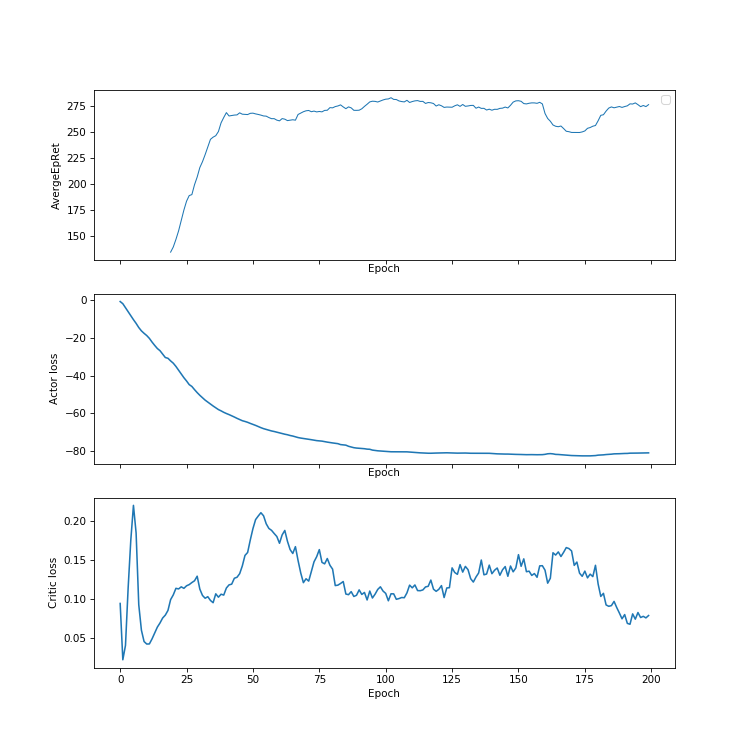

No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


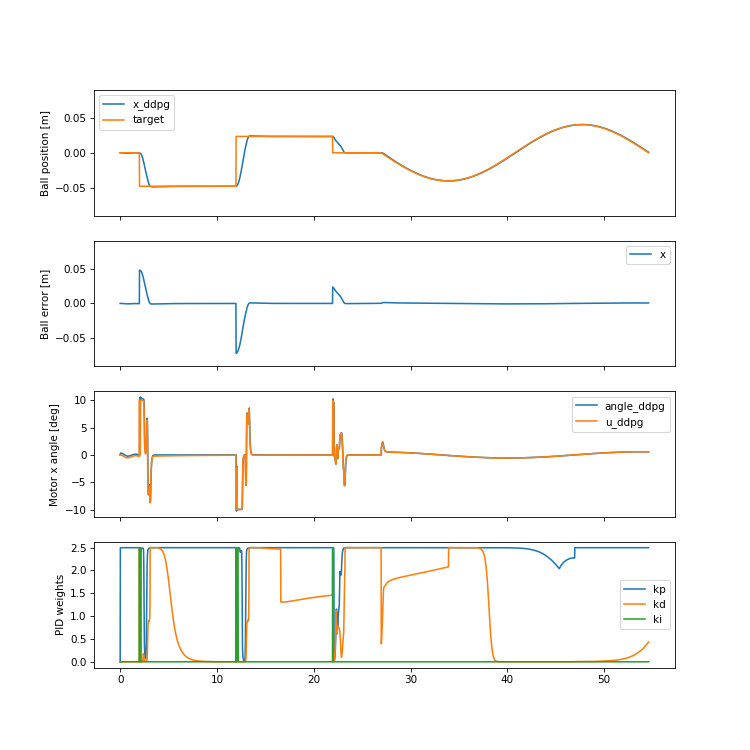

MSE ddpg 7.400266529084031e-05


In [19]:
env = BBEnvPid1D #1
ac = PidActorCritic
reward_fn = linear_e_reward_penality
w = 0.6
hidden_size = [50]
activation = torch.nn.ReLU
replay_size = 75000
name='lep_0.6_[50]_relu_75000'
train_ddpg(env, ac, reward_fn, w, hidden_size, activation, name, replay_size)

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [-0.024378080500752557, -0.003229237402526039], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([0.00355105], dtype=float32), array([-0.01253346], dtype=float32), array([0.00139992], dtype=float32))


/home/benoit/.local/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


<IPython.core.display.Javascript object>


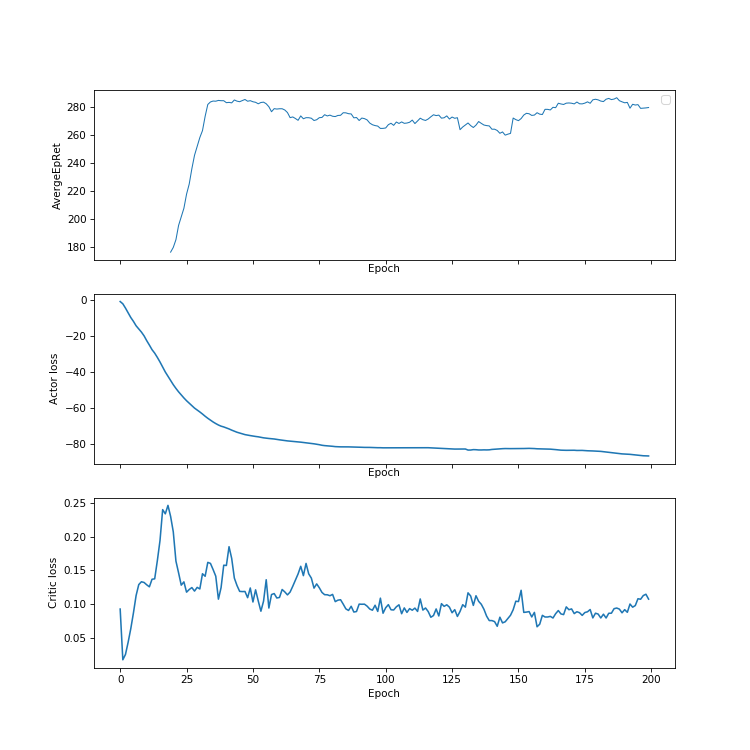

No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


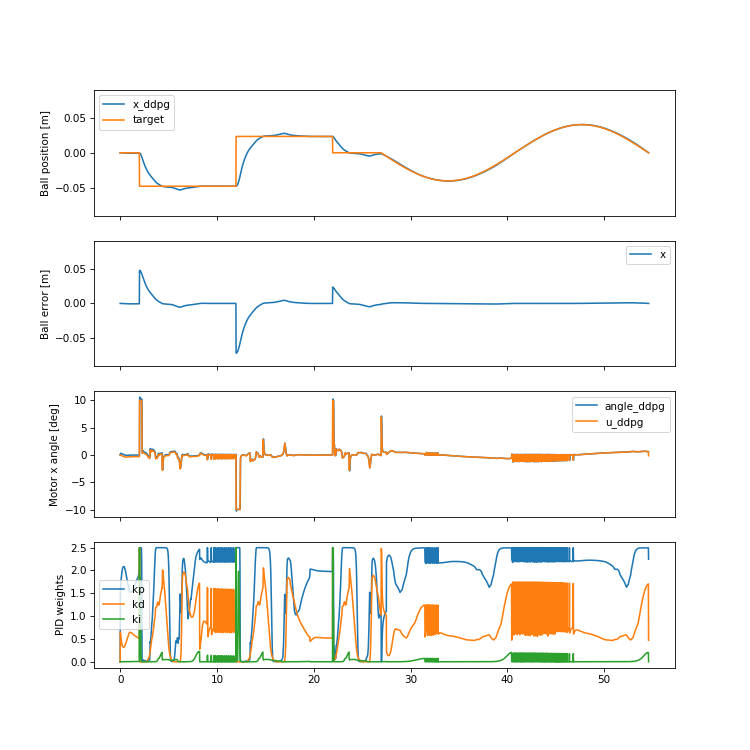

MSE ddpg 8.743535409137094e-05


In [20]:
env = BBEnvPid1D #2
ac = PidActorCritic
reward_fn = linear_e_reward_penality
w = 0.6
hidden_size = [100]
activation = torch.nn.ReLU
replay_size = 75000
name='lep_0.6_[100]_relu_75000'
train_ddpg(env, ac, reward_fn, w, hidden_size, activation, name, replay_size)

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [-0.024378080500752557, -0.003229237402526039], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([-0.0339983], dtype=float32), array([-0.01045049], dtype=float32), array([0.00189698], dtype=float32))


/home/benoit/.local/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


<IPython.core.display.Javascript object>


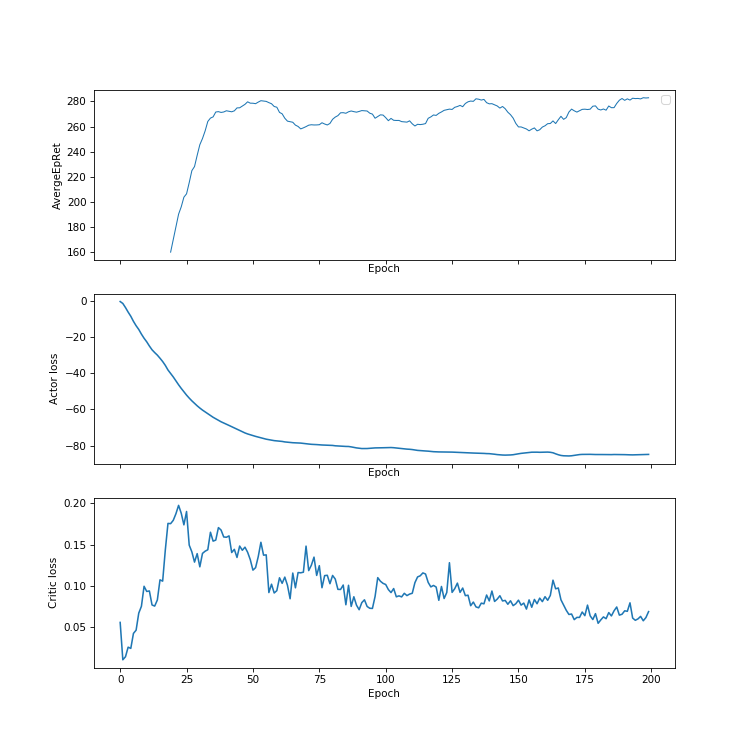

No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


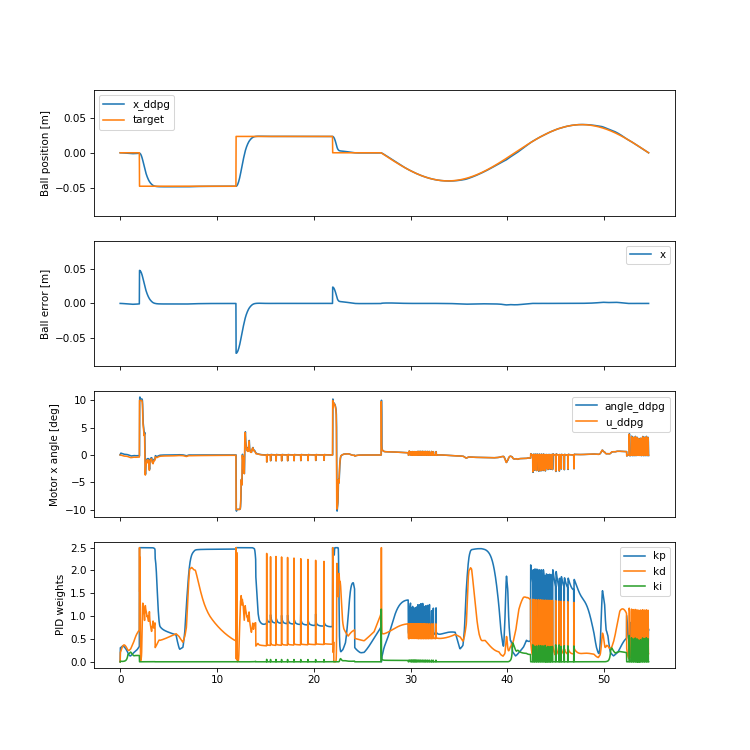

MSE ddpg 7.212780831287904e-05


In [21]:
env = BBEnvPid1D #3
ac = PidActorCritic
reward_fn = linear_e_reward_penality
w = 0.6
hidden_size = [200]
activation = torch.nn.ReLU
replay_size = 75000
name='lep_0.6_[200]_relu_75000'
train_ddpg(env, ac, reward_fn, w, hidden_size, activation, name, replay_size)

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [-0.024378080500752557, -0.003229237402526039], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([-0.03957032], dtype=float32), array([-0.0095264], dtype=float32), array([0.0001295], dtype=float32))


/home/benoit/.local/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


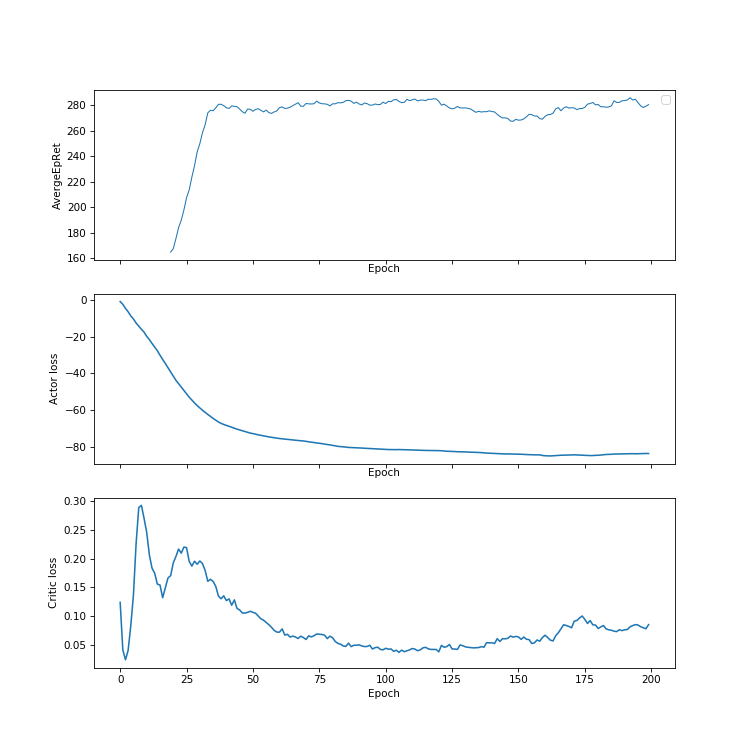

No handles with labels found to put in legend.
/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


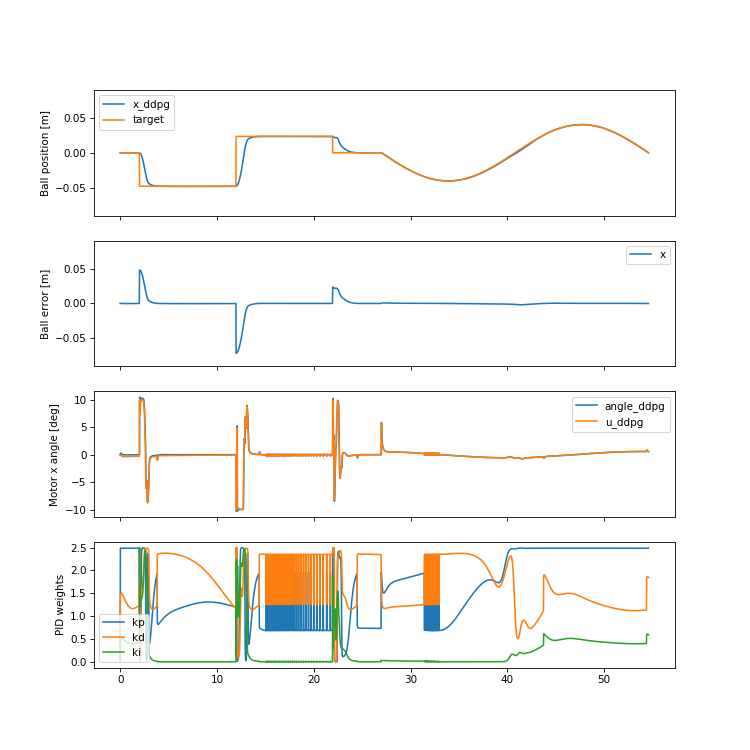

MSE ddpg 7.523072512034968e-05


In [22]:
env = BBEnvPid1D #4
ac = PidActorCritic
reward_fn = linear_e_reward_penality
w = 0.6
hidden_size = [50] 
activation = torch.nn.Sigmoid
replay_size = 75000
name='lep_0.6_[50]_sigmoid_75000'
train_ddpg(env, ac, reward_fn, w, hidden_size, activation, name, replay_size)

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [-0.024378080500752557, -0.003229237402526039], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([-0.0563627], dtype=float32), array([-0.02365616], dtype=float32), array([0.00184673], dtype=float32))


/home/benoit/.local/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


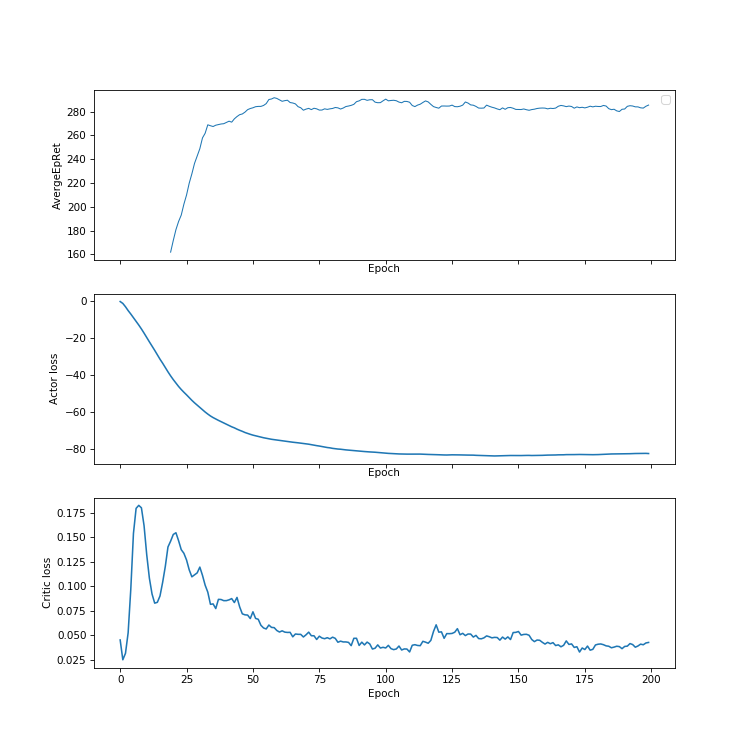

No handles with labels found to put in legend.
/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


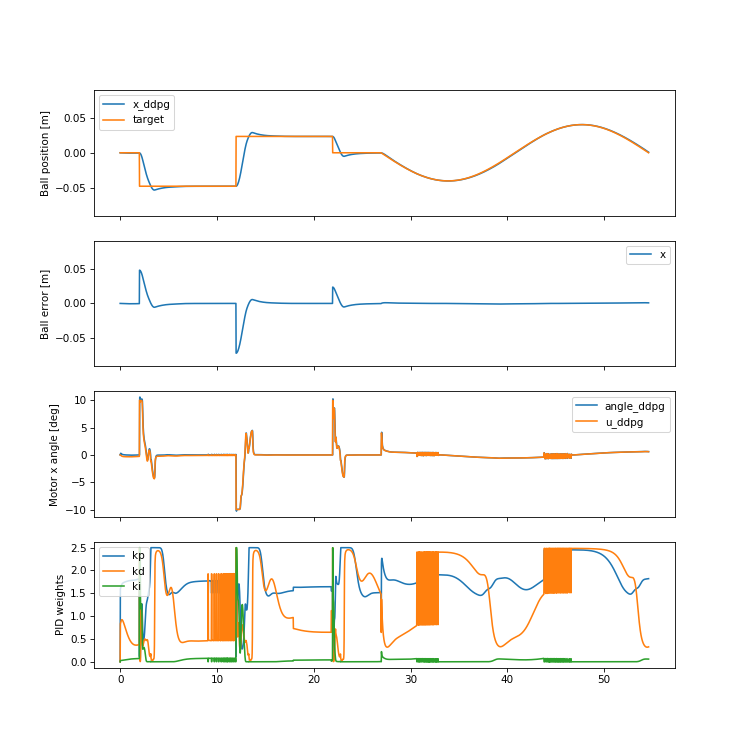

MSE ddpg 7.169637127822709e-05


In [23]:
env = BBEnvPid1D #5
ac = PidActorCritic
reward_fn = linear_e_reward_penality
w = 0.6
hidden_size = [100]
activation = torch.nn.Sigmoid
replay_size = 75000
name='lep_0.6_[100]_sigmoid_75000'
train_ddpg(env, ac, reward_fn, w, hidden_size, activation, name, replay_size)

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [-0.024378080500752557, -0.003229237402526039], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([-0.05044269], dtype=float32), array([0.06233395], dtype=float32), array([-0.00263008], dtype=float32))


/home/benoit/.local/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


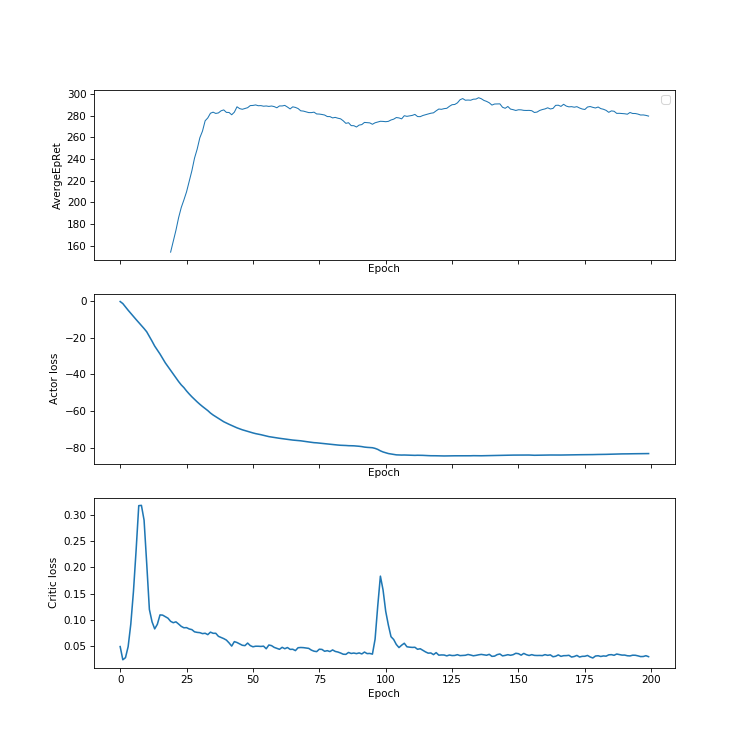

No handles with labels found to put in legend.
/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


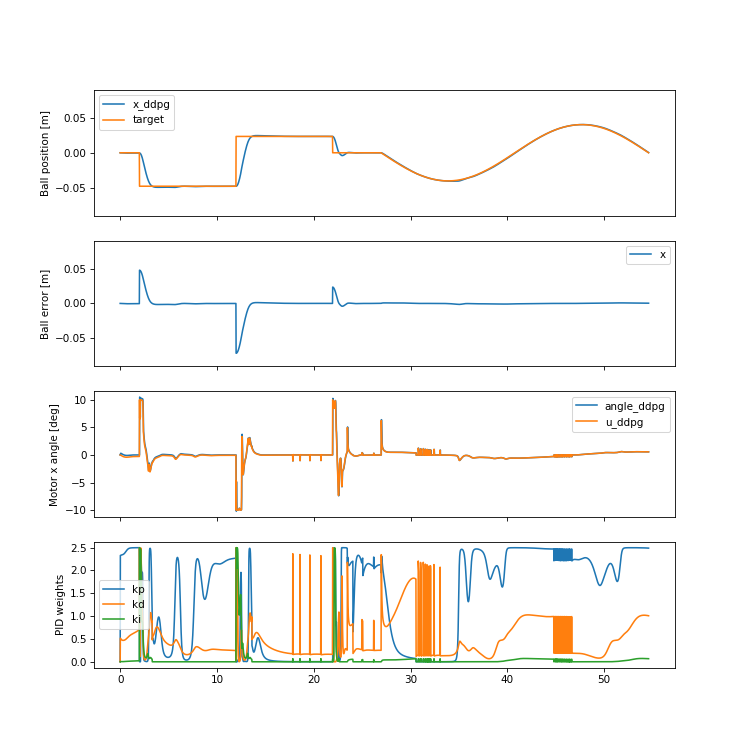

MSE ddpg 7.323315026371123e-05


In [24]:
env = BBEnvPid1D #6
ac = PidActorCritic
reward_fn = linear_e_reward_penality
w = 0.6
hidden_size = [200]
activation = torch.nn.Sigmoid
replay_size = 75000
name='lep_0.6_[200]_sigmoid_75000'
train_ddpg(env, ac, reward_fn, w, hidden_size, activation, name, replay_size)

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [-0.024378080500752557, -0.003229237402526039], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([-0.00126492], dtype=float32), array([-0.02760947], dtype=float32), array([0.00156916], dtype=float32))


/home/benoit/.local/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


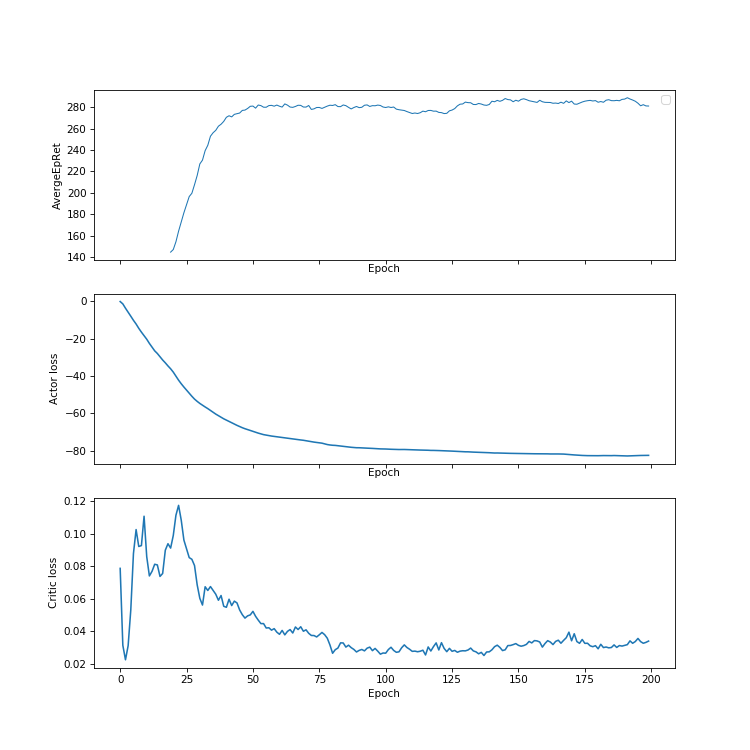

No handles with labels found to put in legend.
/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


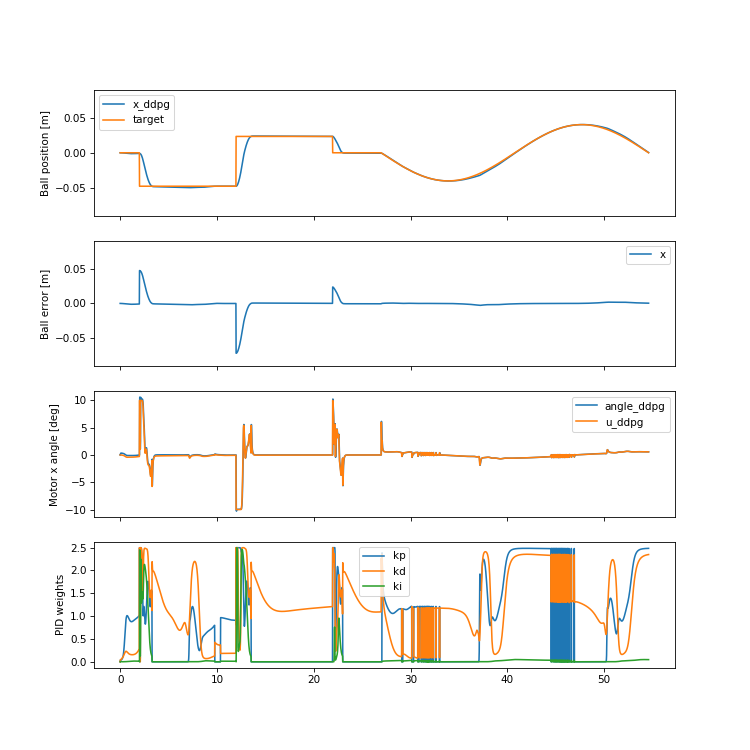

MSE ddpg 7.243323886463878e-05


In [25]:
env = BBEnvPid1D #7
ac = PidActorCritic
reward_fn = linear_e_reward_penality
w = 0.6
hidden_size = [50,25]
activation = torch.nn.Sigmoid
replay_size = 75000
name='lep_0.6_[50,25]_sigmoid_75000'
train_ddpg(env, ac, reward_fn, w, hidden_size, activation, name, replay_size)

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [-0.024378080500752557, -0.003229237402526039], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([0.03657554], dtype=float32), array([0.03933756], dtype=float32), array([-0.0026302], dtype=float32))


/home/benoit/.local/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


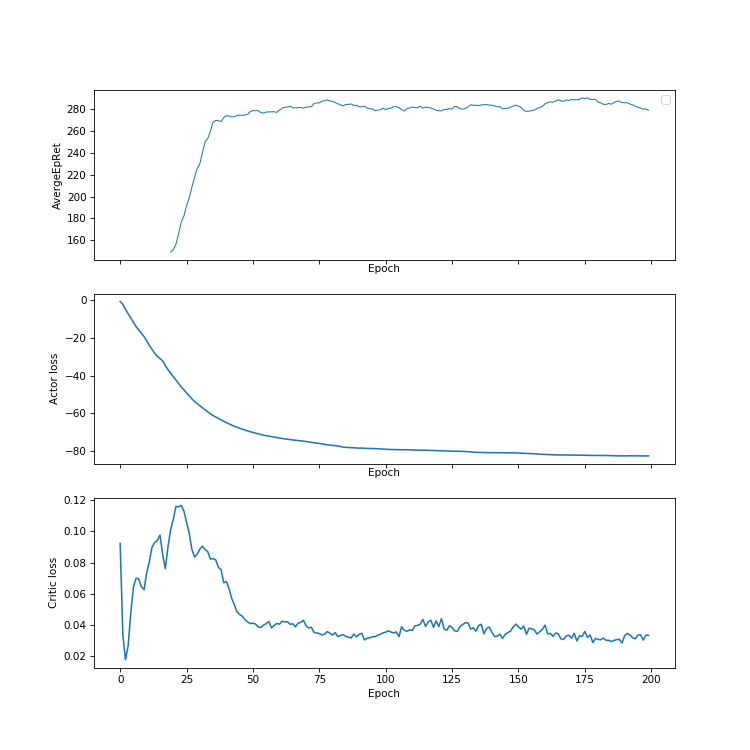

No handles with labels found to put in legend.
/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


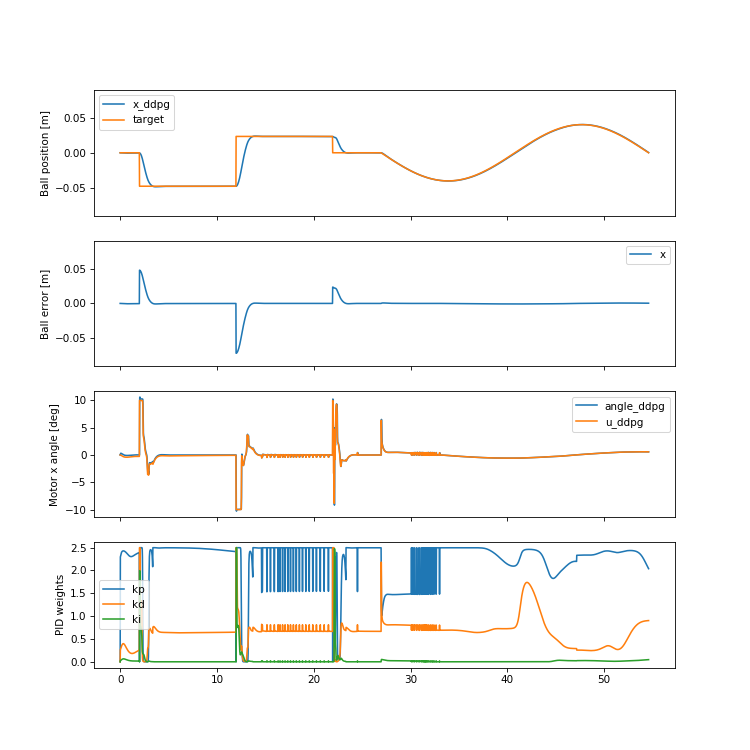

MSE ddpg 7.319808011412275e-05


In [26]:
env = BBEnvPid1D #8
ac = PidActorCritic 
reward_fn = linear_e_reward_penality
w = 0.6
hidden_size = [50,50]
activation = torch.nn.Sigmoid
replay_size = 75000
name='lep_0.6_[50,50]_sigmoid_75000'
train_ddpg(env, ac, reward_fn, w, hidden_size, activation, name, replay_size)

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [-0.024378080500752557, -0.003229237402526039], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([-0.06521336], dtype=float32), array([-0.01532601], dtype=float32), array([0.00079069], dtype=float32))


/home/benoit/.local/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


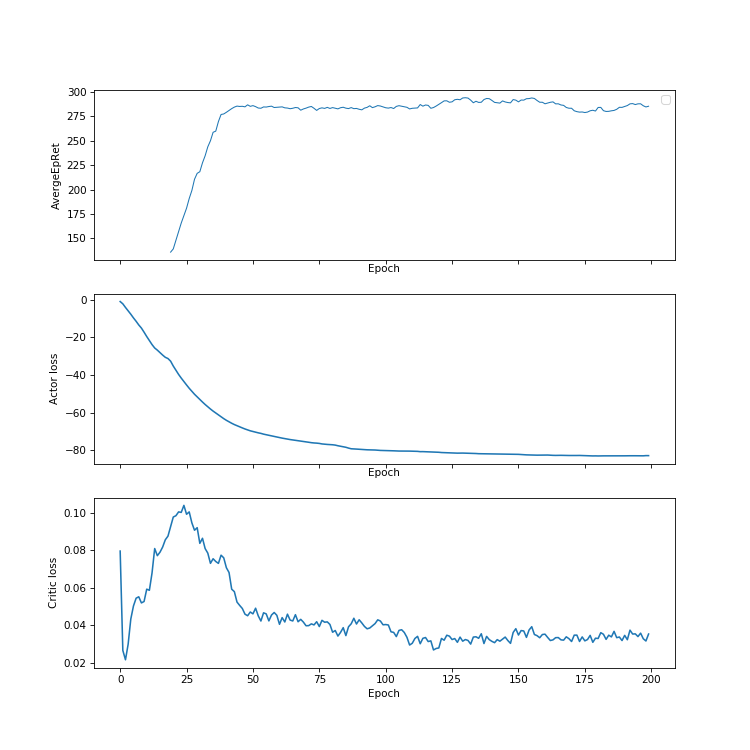

No handles with labels found to put in legend.
/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


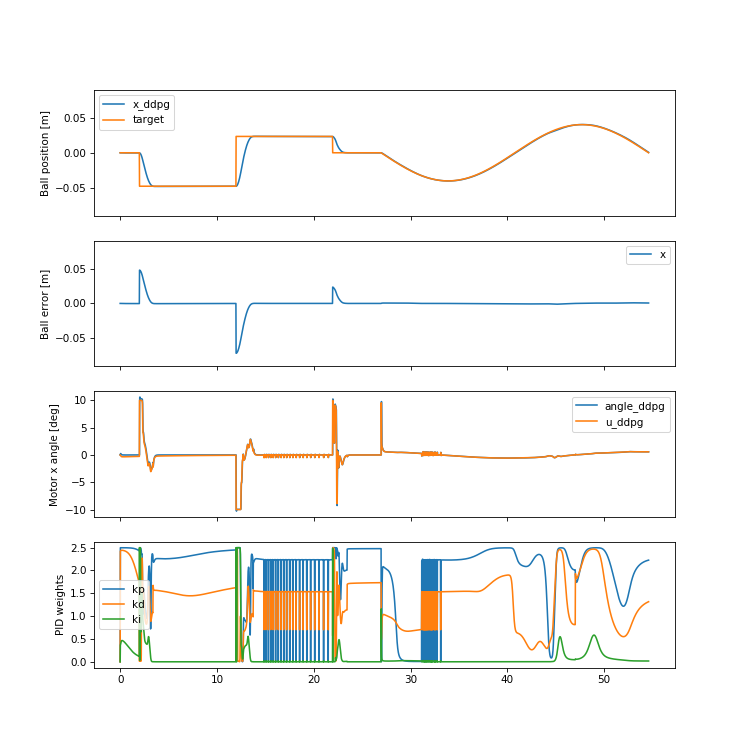

MSE ddpg 7.212567831311505e-05


In [27]:
env = BBEnvPid1D #9
ac = PidActorCritic
reward_fn = linear_e_reward_penality
w = 0.6
hidden_size = [100,50]
activation = torch.nn.Sigmoid
replay_size = 75000
name='lep_0.6_[100,50]_sigmoid_75000'
train_ddpg(env, ac, reward_fn, w, hidden_size, activation, name, replay_size)

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [-0.024378080500752557, -0.003229237402526039], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([0.00521217], dtype=float32), array([-0.06117678], dtype=float32), array([-0.00179693], dtype=float32))


/home/benoit/.local/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


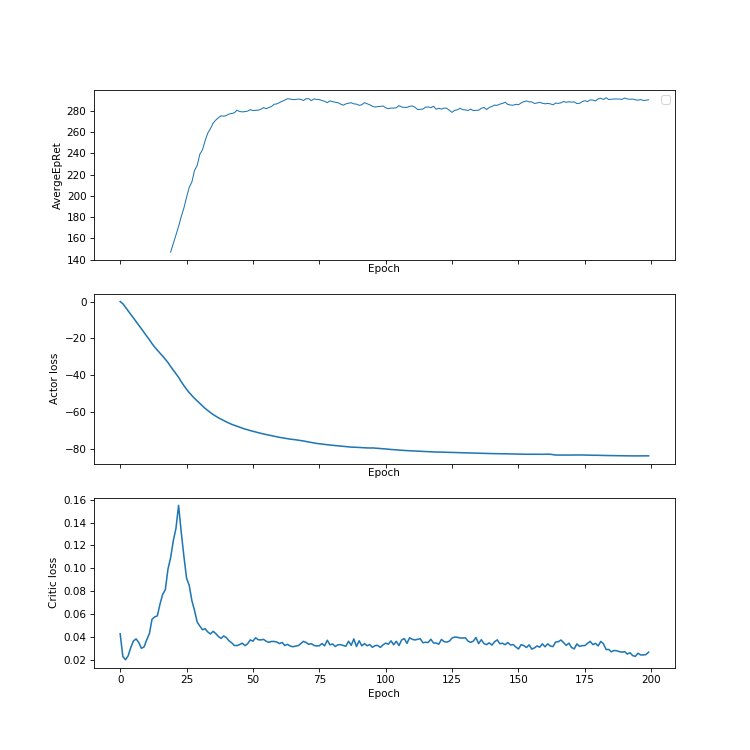

No handles with labels found to put in legend.
/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


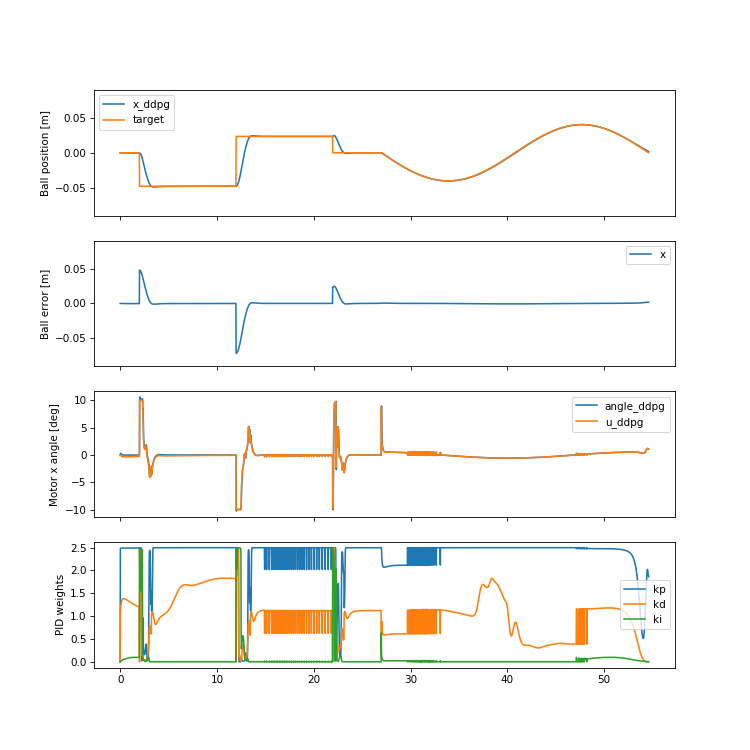

MSE ddpg 7.313297868686273e-05


In [28]:
env = BBEnvPid1D #10
ac = PidActorCritic 
reward_fn = linear_e_reward_penality
w = 0.6
hidden_size = [100,100]
activation = torch.nn.Sigmoid
replay_size = 75000
name='lep_0.6_[100,100]_sigmoid_75000'
train_ddpg(env, ac, reward_fn, w, hidden_size, activation, name, replay_size)

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [-0.024378080500752557, -0.003229237402526039], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([0.01743989], dtype=float32), array([0.03341283], dtype=float32), array([-0.00106805], dtype=float32))


/home/benoit/.local/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


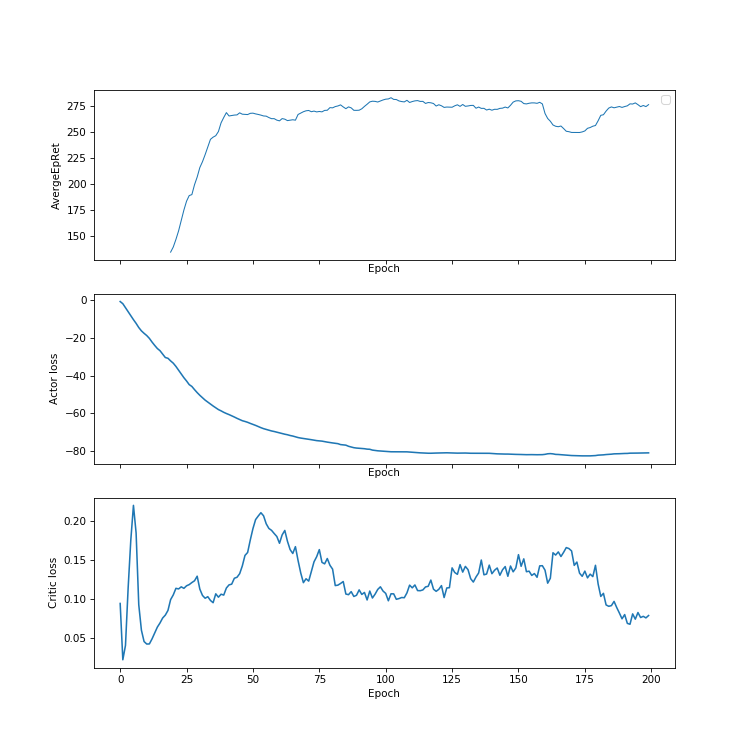

No handles with labels found to put in legend.
/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


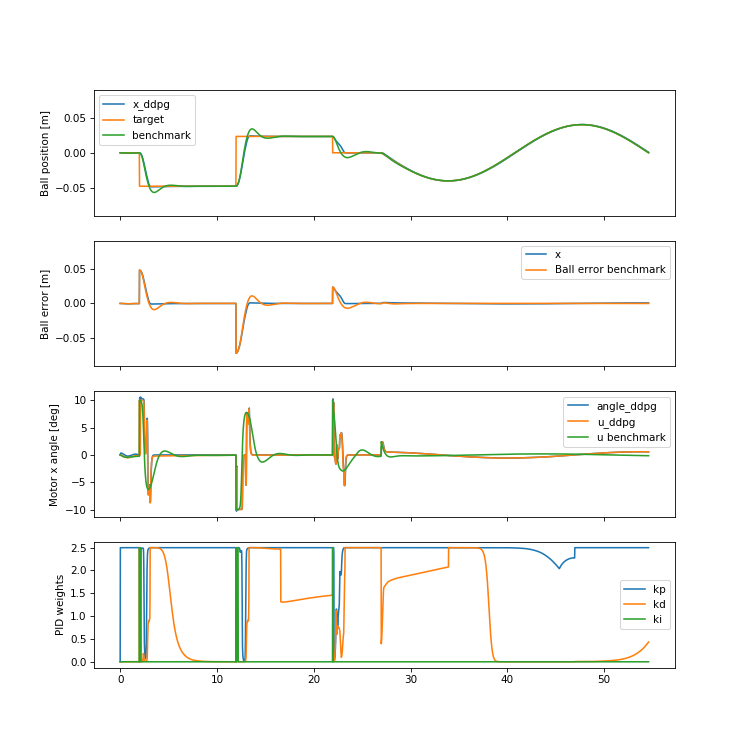

MSE ddpg 7.400266529084031e-05
MSE benchmark 7.275388054105533e-05


In [29]:
env = BBEnvPid1D
ac = PidActorCritic
reward_fn = linear_e_reward_penality
w = 0.6
hidden_size = [50]
activation = torch.nn.ReLU
replay_size = 75000
name='lep_0.6_[50]_relu_75000'
train_ddpg(env, ac, reward_fn, w, hidden_size, activation, name, replay_size, show_benchmark=True)

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [-0.024378080500752557, -0.003229237402526039], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([0.06212855], dtype=float32), array([0.01225497], dtype=float32), array([-0.00191452], dtype=float32))


/home/benoit/.local/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


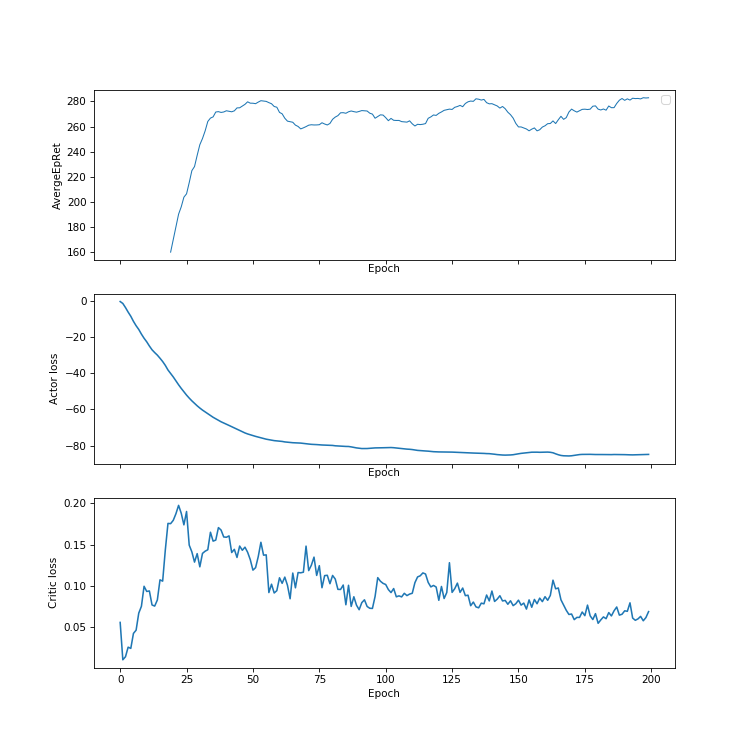

No handles with labels found to put in legend.
/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


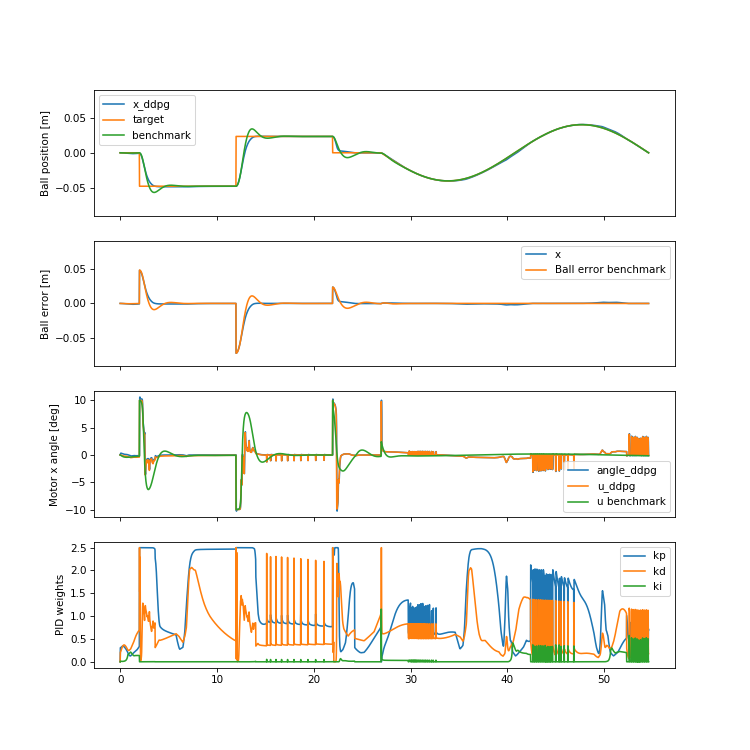

MSE ddpg 7.212780831287904e-05
MSE benchmark 7.275388054105533e-05


In [30]:
env = BBEnvPid1D
ac = PidActorCritic
reward_fn = linear_e_reward_penality
w = 0.6
hidden_size = [200]
activation = torch.nn.ReLU
replay_size = 75000
name='lep_0.6_[200]_relu_75000'
train_ddpg(env, ac, reward_fn, w, hidden_size, activation, name, replay_size, show_benchmark=True)

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [-0.024378080500752557, -0.003229237402526039], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([-0.01039475], dtype=float32), array([-0.04874336], dtype=float32), array([-0.00211142], dtype=float32))


/home/benoit/.local/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


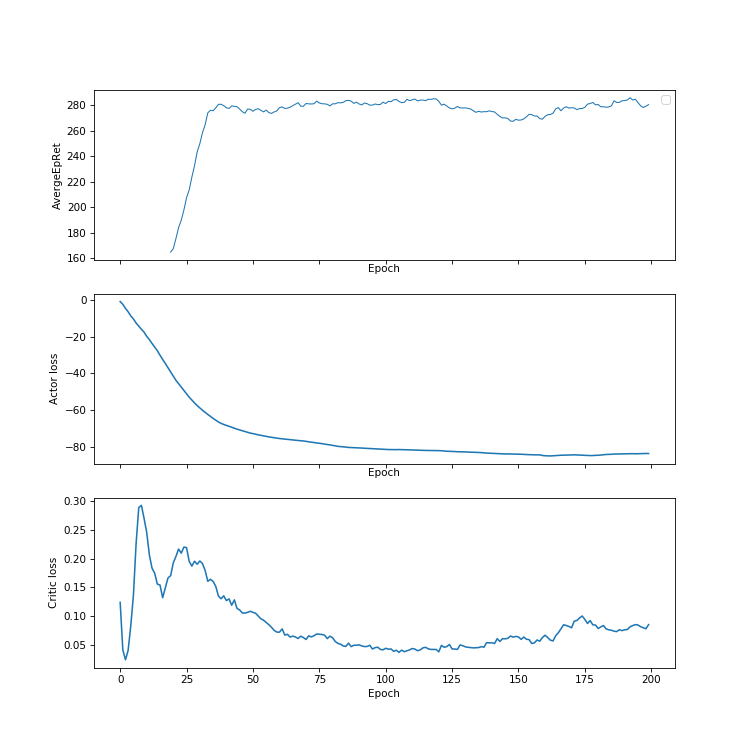

No handles with labels found to put in legend.
/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


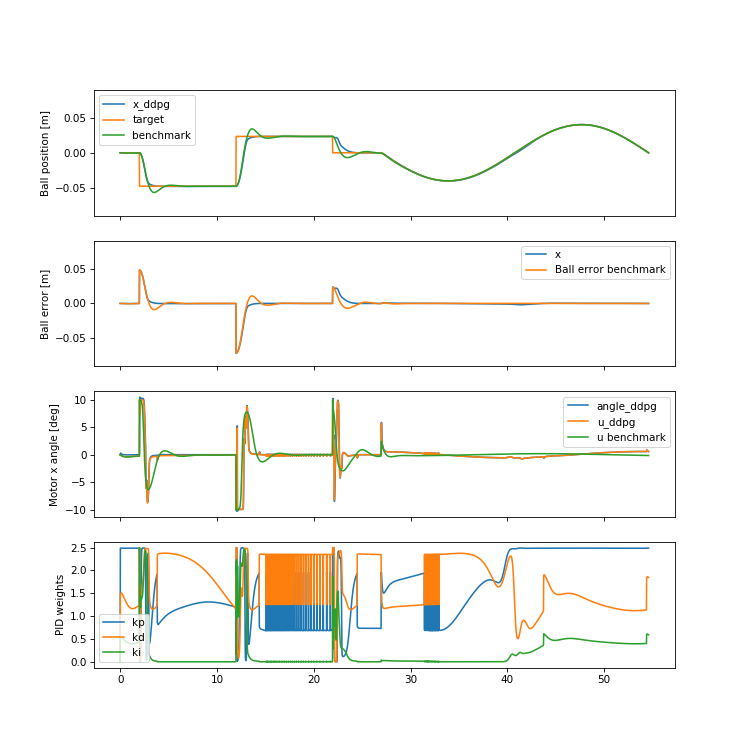

MSE ddpg 7.523072512034968e-05
MSE benchmark 7.275388054105533e-05


In [31]:
env = BBEnvPid1D 
ac = PidActorCritic
reward_fn = linear_e_reward_penality
w = 0.6
hidden_size = [50] 
activation = torch.nn.Sigmoid
replay_size = 75000
name='lep_0.6_[50]_sigmoid_75000'
train_ddpg(env, ac, reward_fn, w, hidden_size, activation, name, replay_size, show_benchmark=True)

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [-0.024378080500752557, -0.003229237402526039], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([-0.04618996], dtype=float32), array([0.07106561], dtype=float32), array([0.00232265], dtype=float32))


/home/benoit/.local/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


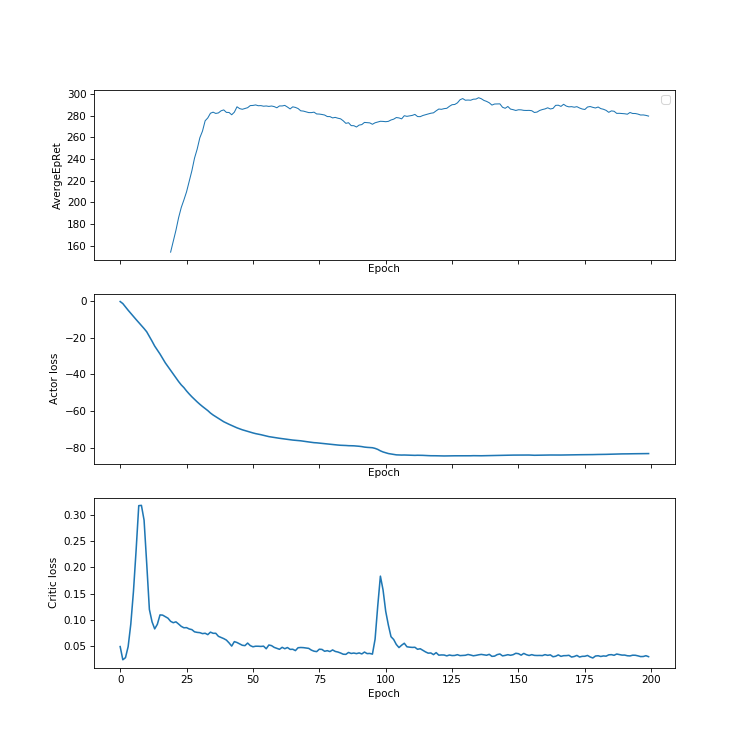

No handles with labels found to put in legend.
/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


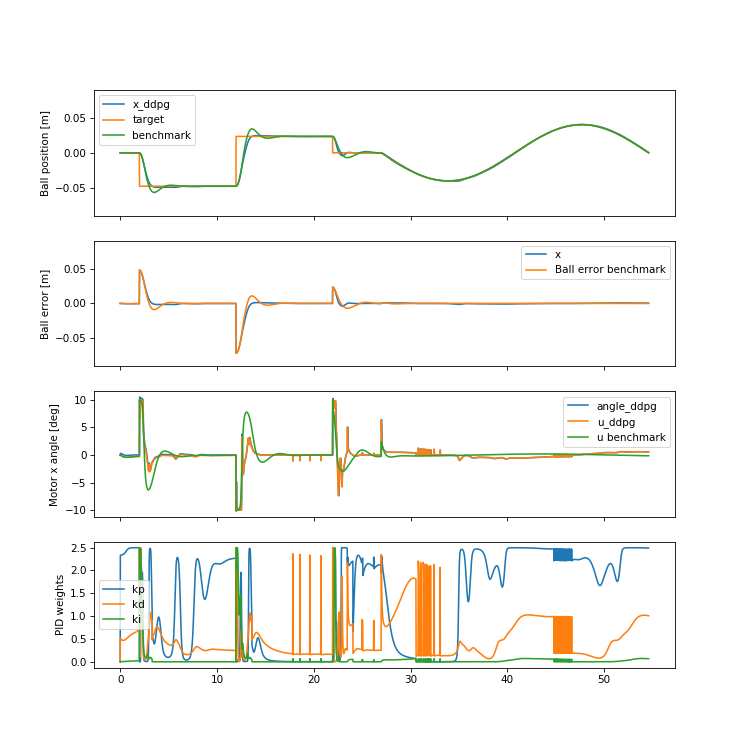

MSE ddpg 7.323315026371123e-05
MSE benchmark 7.275388054105533e-05


In [32]:
env = BBEnvPid1D
ac = PidActorCritic
reward_fn = linear_e_reward_penality
w = 0.6
hidden_size = [200]
activation = torch.nn.Sigmoid
replay_size = 75000
name='lep_0.6_[200]_sigmoid_75000'
train_ddpg(env, ac, reward_fn, w, hidden_size, activation, name, replay_size, show_benchmark=True)

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [-0.024378080500752557, -0.003229237402526039], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([-0.03205876], dtype=float32), array([0.04315973], dtype=float32), array([0.00110739], dtype=float32))


/home/benoit/.local/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


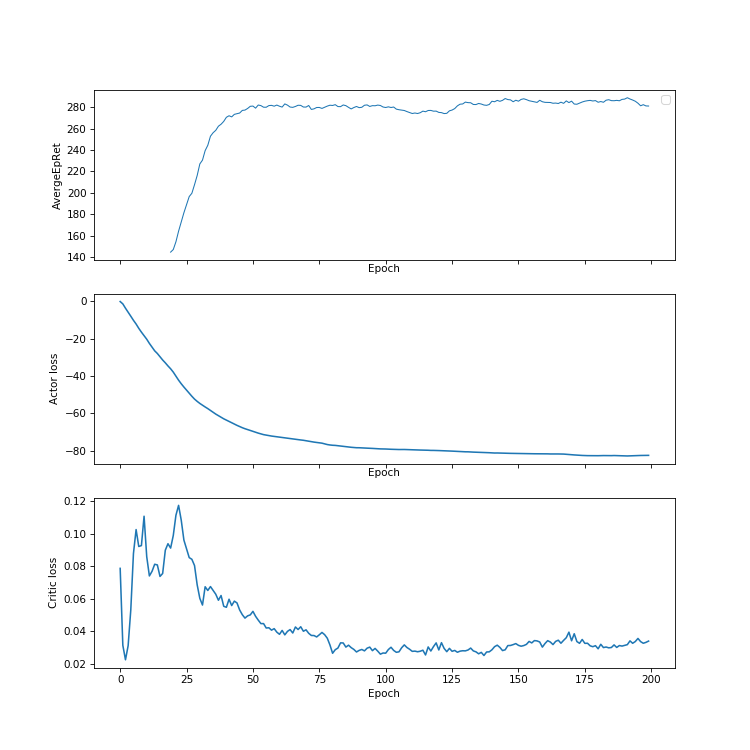

No handles with labels found to put in legend.
/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


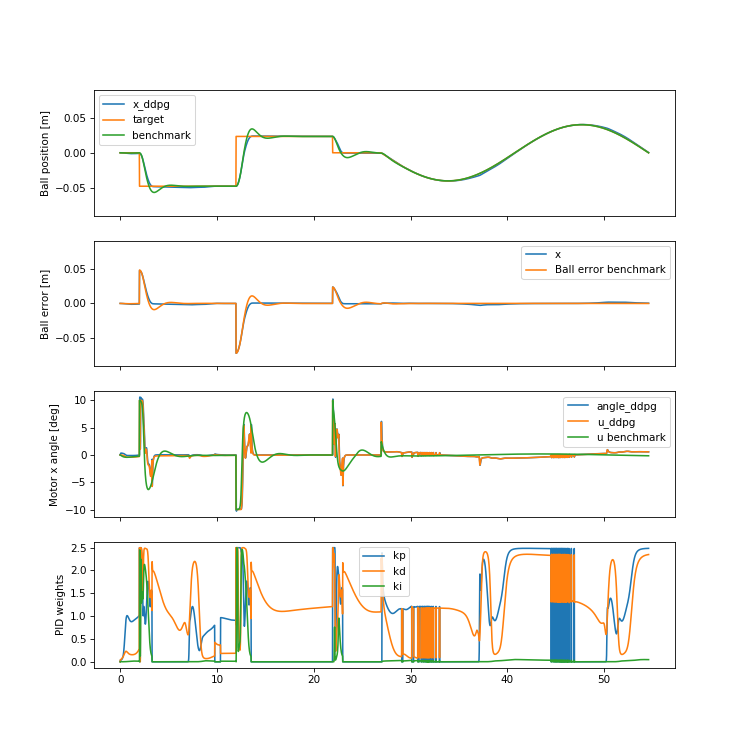

MSE ddpg 7.243323886463878e-05
MSE benchmark 7.275388054105533e-05


In [33]:
env = BBEnvPid1D
ac = PidActorCritic
reward_fn = linear_e_reward_penality
w = 0.6
hidden_size = [50,25]
activation = torch.nn.Sigmoid
replay_size = 75000
name='lep_0.6_[50,25]_sigmoid_75000'
train_ddpg(env, ac, reward_fn, w, hidden_size, activation, name, replay_size, show_benchmark=True)

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [-0.024378080500752557, -0.003229237402526039], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([-0.04604966], dtype=float32), array([0.01490841], dtype=float32), array([0.00072622], dtype=float32))


/home/benoit/.local/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


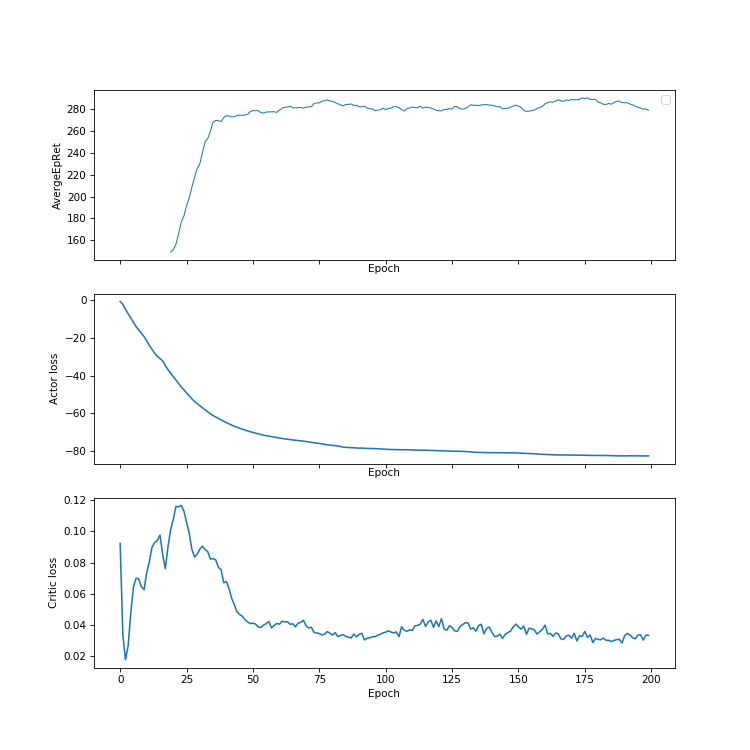

No handles with labels found to put in legend.
/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


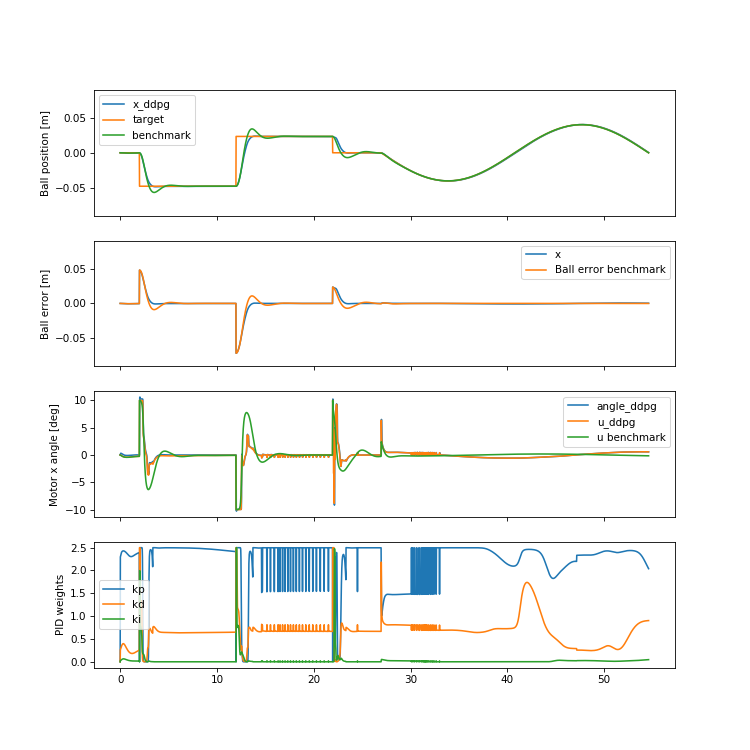

MSE ddpg 7.319808011412275e-05
MSE benchmark 7.275388054105533e-05


In [34]:
env = BBEnvPid1D
ac = PidActorCritic
reward_fn = linear_e_reward_penality
w = 0.6
hidden_size = [50,50]
activation = torch.nn.Sigmoid
replay_size = 75000
name='lep_0.6_[50,50]_sigmoid_75000'
train_ddpg(env, ac, reward_fn, w, hidden_size, activation, name, replay_size, show_benchmark=True)

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [-0.024378080500752557, -0.003229237402526039], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([0.05612781], dtype=float32), array([0.07094269], dtype=float32), array([-0.00074121], dtype=float32))


/home/benoit/.local/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


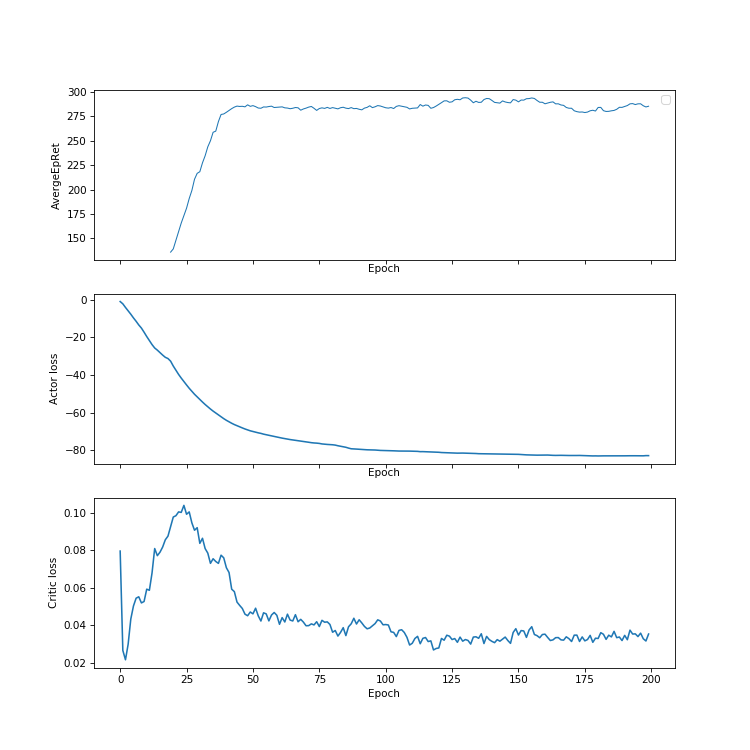

No handles with labels found to put in legend.
/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


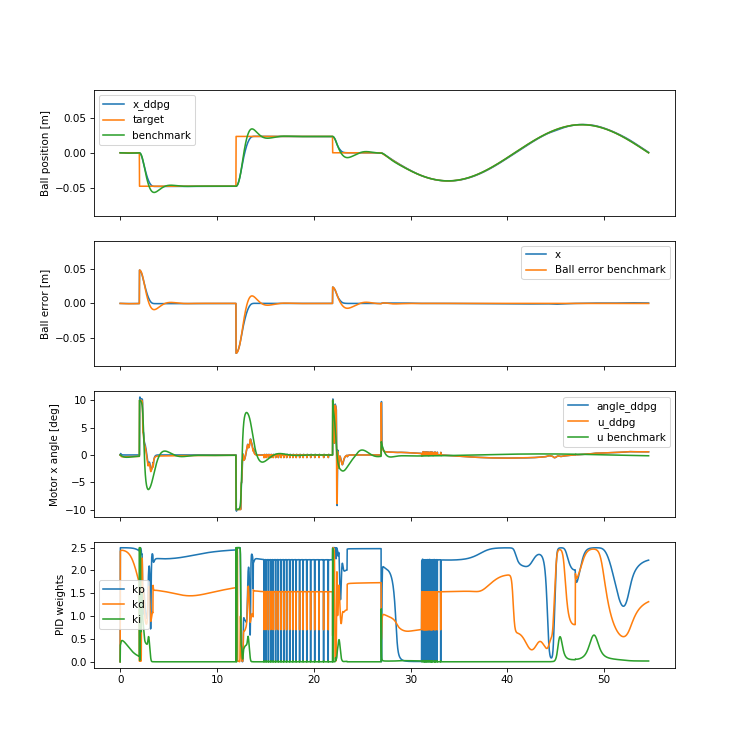

MSE ddpg 7.212567831311505e-05
MSE benchmark 7.275388054105533e-05


In [35]:
env = BBEnvPid1D
ac = PidActorCritic
reward_fn = linear_e_reward_penality
w = 0.6
hidden_size = [100,50]
activation = torch.nn.Sigmoid
replay_size = 75000
name='lep_0.6_[100,50]_sigmoid_75000'
train_ddpg(env, ac, reward_fn, w, hidden_size, activation, name, replay_size, show_benchmark=True)

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [-0.024378080500752557, -0.003229237402526039], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([-0.01212245], dtype=float32), array([-0.03298233], dtype=float32), array([-0.00223375], dtype=float32))


/home/benoit/.local/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


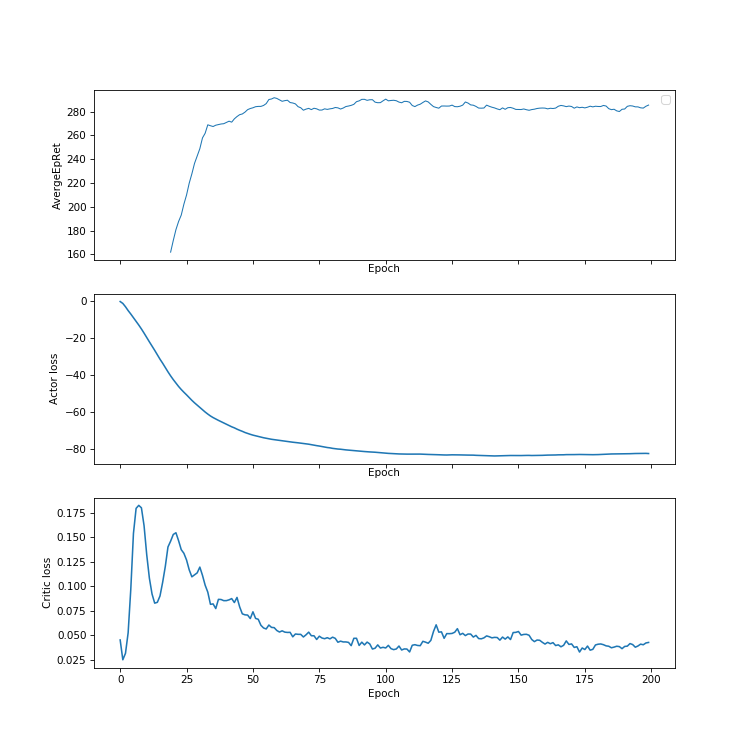

No handles with labels found to put in legend.
/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


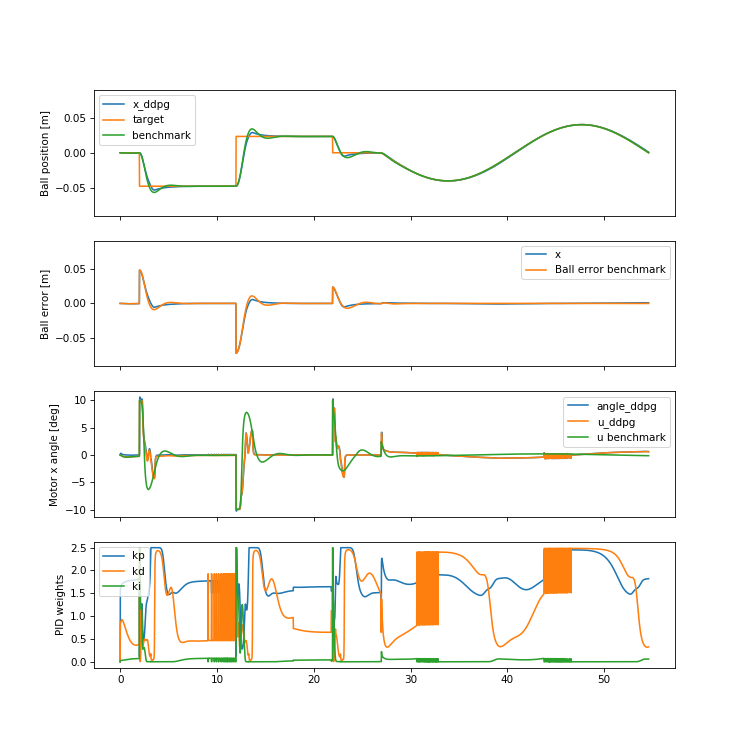

MSE ddpg 7.169637127822709e-05
MSE benchmark 7.275388054105533e-05


In [36]:
env = BBEnvPid1D #5
ac = PidActorCritic
reward_fn = linear_e_reward_penality
w = 0.6
hidden_size = [100]
activation = torch.nn.Sigmoid
replay_size = 75000
name='lep_0.6_[100]_sigmoid_75000'
train_ddpg(env, ac, reward_fn, w, hidden_size, activation, name, replay_size, show_benchmark=True)